**1.Target:**

1.   Create lighter model architecture

**2.Results**:

1.   Parameters :4990
2.   Best Train Accuracy: 96.84
3.   Best Test Accuracy: 97.16


**3.Analysis:**

Model has 8790 paramter since train accuracy is less than test accuracy hence there is a chances of improvement

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 236684207.72it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 14524663.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68323994.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2660316.82it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dropout_value = .05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels= 10,kernel_size= (3, 3), padding=1, bias=False),    #output_image = 28, RF=3
            nn.ReLU()
            )
        #CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels= 20,kernel_size= (3, 3), padding=1, bias=False),    #output_image = 28, RF=5
            nn.ReLU()
        )

        #TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)    #output_image = 14, RF=6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels= 10,kernel_size= (1, 1), padding=0, bias=False),    #output_image = 14, RF=6
            nn.ReLU()
        )

        #CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels= 10,kernel_size= (3, 3), padding=1, bias=False),    #output_image = 14, RF=10
            nn.ReLU()
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10,out_channels= 20,kernel_size= (3, 3), padding=1, bias=False),    #output_image = 14, RF=14
            nn.ReLU()
        )

        #TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2)    #output_image = 7, RF=16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels= 10,kernel_size= (1, 1), padding=0, bias=False),    #output_image = 7, RF=24
            nn.ReLU()
        )

        #CONVOLUTION BLOCK 3
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)

        )


    def forward(self, x):
      x = self.convblock1(x)
      x = self.convblock2(x)
      x = self.pool1(x)
      x = self.convblock3(x)
      x = self.convblock4(x)
      x = self.convblock5(x)
      x = self.pool2(x)
      x = self.convblock6(x)
      x = self.gap(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 20, 28, 28]           1,800
              ReLU-4           [-1, 20, 28, 28]               0
         MaxPool2d-5           [-1, 20, 14, 14]               0
            Conv2d-6           [-1, 10, 14, 14]             200
              ReLU-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             900
              ReLU-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 20, 14, 14]           1,800
             ReLU-11           [-1, 20, 14, 14]               0
        MaxPool2d-12             [-1, 20, 7, 7]               0

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=2.294542074203491 Batch_id=468 Accuracy=10.35: 100%|██████████| 469/469 [00:23<00:00, 20.18it/s]



Test set: Average loss: 2.2977, Accuracy: 1149/10000 (11.49%)

EPOCH: 1


Loss=2.0480551719665527 Batch_id=468 Accuracy=14.09: 100%|██████████| 469/469 [00:17<00:00, 26.29it/s]



Test set: Average loss: 2.0032, Accuracy: 3987/10000 (39.87%)

EPOCH: 2


Loss=0.29418590664863586 Batch_id=468 Accuracy=70.08: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]



Test set: Average loss: 0.4274, Accuracy: 8676/10000 (86.76%)

EPOCH: 3


Loss=0.17073412239551544 Batch_id=468 Accuracy=89.89: 100%|██████████| 469/469 [00:17<00:00, 26.91it/s]



Test set: Average loss: 0.2744, Accuracy: 9172/10000 (91.72%)

EPOCH: 4


Loss=0.25777196884155273 Batch_id=468 Accuracy=92.97: 100%|██████████| 469/469 [00:17<00:00, 27.44it/s]



Test set: Average loss: 0.1837, Accuracy: 9435/10000 (94.35%)

EPOCH: 5


Loss=0.17087282240390778 Batch_id=468 Accuracy=94.37: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]



Test set: Average loss: 0.1694, Accuracy: 9489/10000 (94.89%)

EPOCH: 6


Loss=0.1587909311056137 Batch_id=468 Accuracy=95.20: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]



Test set: Average loss: 0.1753, Accuracy: 9471/10000 (94.71%)

EPOCH: 7


Loss=0.17424100637435913 Batch_id=468 Accuracy=95.64: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]



Test set: Average loss: 0.1328, Accuracy: 9606/10000 (96.06%)

EPOCH: 8


Loss=0.09063496440649033 Batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]



Test set: Average loss: 0.1105, Accuracy: 9682/10000 (96.82%)

EPOCH: 9


Loss=0.3881990909576416 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:16<00:00, 28.72it/s]



Test set: Average loss: 0.1167, Accuracy: 9649/10000 (96.49%)

EPOCH: 10


Loss=0.07311578840017319 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]



Test set: Average loss: 0.1107, Accuracy: 9672/10000 (96.72%)

EPOCH: 11


Loss=0.08140658587217331 Batch_id=468 Accuracy=96.68: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]



Test set: Average loss: 0.1155, Accuracy: 9647/10000 (96.47%)

EPOCH: 12


Loss=0.220150887966156 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]



Test set: Average loss: 0.0917, Accuracy: 9716/10000 (97.16%)

EPOCH: 13


Loss=0.15019361674785614 Batch_id=468 Accuracy=96.80: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]



Test set: Average loss: 0.1045, Accuracy: 9696/10000 (96.96%)

EPOCH: 14


Loss=0.12835484743118286 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]



Test set: Average loss: 0.0984, Accuracy: 9700/10000 (97.00%)



Text(0.5, 1.0, 'Test Accuracy')

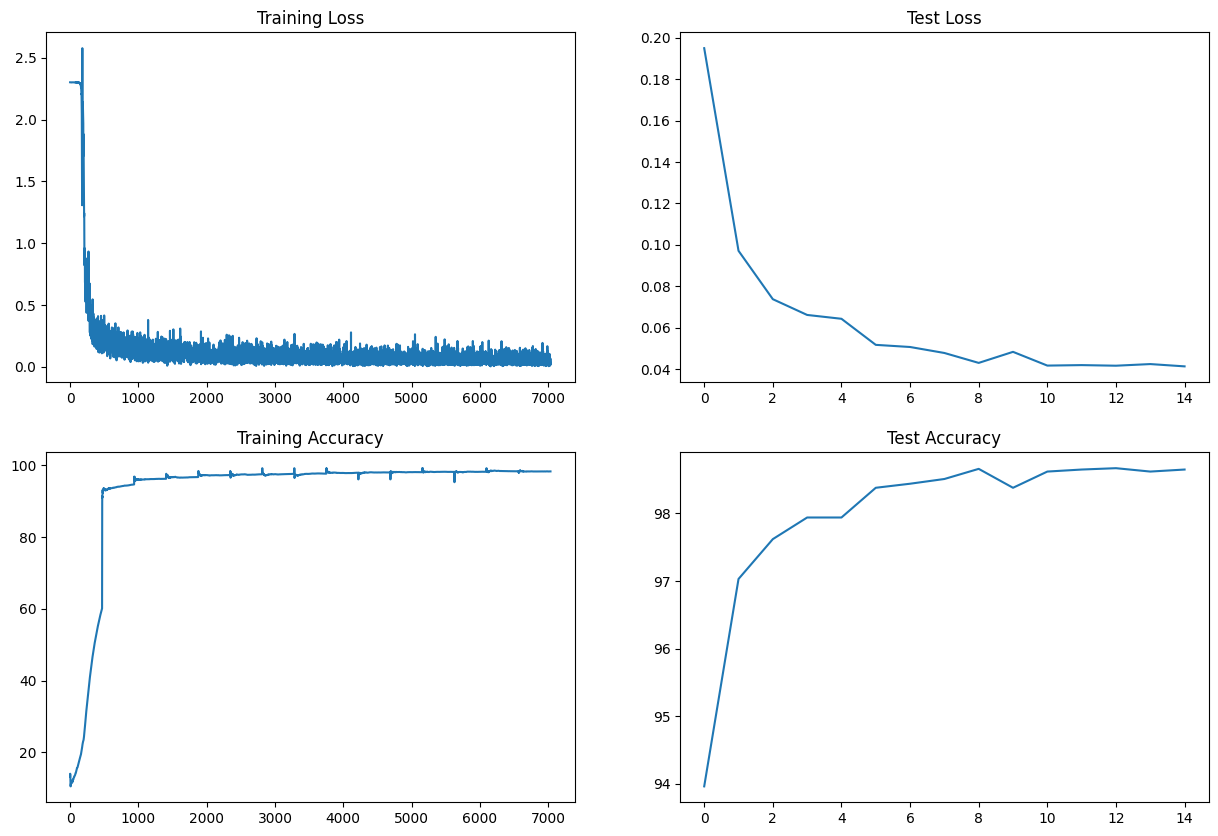

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")